In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [5]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
df_full = pd.read_csv('car_fuel_efficiency.csv')

--2025-11-07 20:27:20--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.2’

car_fuel_efficiency 100%[===================>] 853.70K  3.76MB/s    in 0.2s    

2025-11-07 20:27:20 (3.76 MB/s) - ‘car_fuel_efficiency.csv.2’ saved [874188/874188]



In [16]:
# data prep
def zeroes_missing_values(df):
    return df.fillna(0)

def means_missing_values(df, df_train):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df_train[col].mean())
    return df

In [7]:
def train_val_test_split(df, val_size=0.2, test_size=0.2, random_state=42):
    
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_size)
    val_set_size = int(len(df) * val_size)
    test_indices = shuffled_indices[:test_set_size]
    val_indices = shuffled_indices[test_set_size:test_set_size + val_set_size]
    train_indices = shuffled_indices[test_set_size + val_set_size:]
    return df.iloc[train_indices], df.iloc[val_indices], df.iloc[test_indices]

50th percentile of horsepower: 149.0


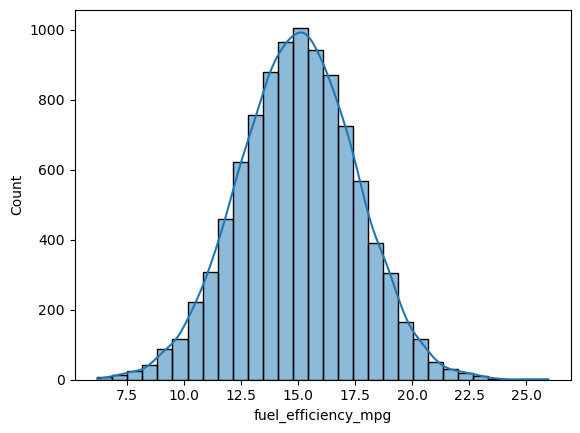

In [13]:
# which has missing values: horsepower is answer
df_full.isnull().sum()

# EDA- this one does not have long tail- its a beautiful bell curve
sns.histplot(df_full['fuel_efficiency_mpg'], bins=30, kde=True)

#Q3: 149
print("50th percentile of horsepower:", df_full['horsepower'].median())

In [29]:
def linear_regression(X, y, alpha=0):
    X_matrix = X.to_numpy()
    X_matrix = np.column_stack((np.ones(X_matrix.shape[0]), X_matrix))  # add intercept
    XTX_matrix = X_matrix.T.dot(X_matrix)
    XTX_alpha_matrix = XTX_matrix + alpha * np.eye(XTX_matrix.shape[0])
    XTX_alpha_inv_matrix= np.linalg.inv(XTX_alpha_matrix)

    y_vector = y.to_numpy()
    w = XTX_alpha_inv_matrix.dot(X_matrix.T).dot(y_vector)
    return w

In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())


In [57]:
def predict_y(X, w):
    X_matrix = X
    X_matrix = np.column_stack((np.ones(X_matrix.shape[0]), X_matrix))  # add intercept
    y_pred = X_matrix.dot(w)
    return y_pred

In [24]:
#  train a linear regression model by either subsituting missing values with zeroes or with the mean value of the column.
# mean calculated just from training set - adjusted the the mean filling function
# just use columns from Q1: engine_displacement', 'horsepower', 'vehicle_weight','model_year','fuel_efficiency_mpg'

df_train_noZero, _, _ = train_val_test_split(df_full)

df_zeroed = zeroes_missing_values(df_full)
df_meaned = means_missing_values(df_full, df_train_noZero)

df_train_meaned, df_val_meaned, df_test_meaned = train_val_test_split(df_meaned)
df_train_zeroed, df_val_zeroed, df_test_zeroed = train_val_test_split(df_zeroed)

selected_columns = ['engine_displacement', 'horsepower', 'vehicle_weight','model_year','fuel_efficiency_mpg']

X_train_zeroed = df_train_zeroed[selected_columns].drop('fuel_efficiency_mpg', axis=1)
y_train_zeroed = df_train_zeroed['fuel_efficiency_mpg']
X_train_meaned = df_train_meaned[selected_columns].drop('fuel_efficiency_mpg', axis=1)
y_train_meaned = df_train_meaned['fuel_efficiency_mpg']

w_train_zeroed = linear_regression(X_train_zeroed, y_train_zeroed, 0)
w_train_meaned = linear_regression(X_train_meaned, y_train_meaned, 0)

# validate the w trained on val set
X_val_zeroed = df_val_zeroed[selected_columns].drop('fuel_efficiency_mpg', axis=1)
y_val_zeroed = df_val_zeroed['fuel_efficiency_mpg']
X_val_meaned = df_val_meaned[selected_columns].drop('fuel_efficiency_mpg', axis=1)
y_val_meaned = df_val_meaned['fuel_efficiency_mpg']

y_predict_zeroed = predict_y(X_val_zeroed, w_train_zeroed)
y_predict_meaned = predict_y(X_val_meaned, w_train_meaned)

rmse_score_zeroed = rmse(y_val_zeroed, y_predict_zeroed)
rmse_score_meaned = rmse(y_val_meaned, y_predict_meaned)

print("RMSE with zeroed missing values:", round(rmse_score_zeroed, 2))
print("RMSE with meaned missing values:", round(rmse_score_meaned, 2))


RMSE with zeroed missing values: 0.52
RMSE with meaned missing values: 0.46


In [30]:
# try regression with regularization
alphas = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_score_mean = []
rmse_score_zero = []

for alpha in alphas:

    w_train_zero_curr = linear_regression(X_train_zeroed, y_train_zeroed,  alpha=alpha)
    y_predict_zero_curr = predict_y(X_val_zeroed, w_train_zero_curr)
    rmse_score_zero.append(rmse(y_val_zeroed, y_predict_zero_curr))

print(np.round(rmse_score_zero, 3).tolist())

[0.458, 0.458, 0.458, 0.458, 0.458, 0.458, 0.458]
[0.518, 0.518, 0.518, 0.518, 0.518, 0.518, 0.518]


In [59]:
# Question 5: do whole thing with diff random seed, zeroes missing values, alpha=0 
# we want rmse vs seed
rand_seeds = np.arange(0, 10)
selected_columns = ['engine_displacement', 'horsepower', 'vehicle_weight','model_year','fuel_efficiency_mpg']
rmse_scores_seeds = []

for seed in rand_seeds:
    df_train_curr, df_val_curr, _ = train_val_test_split(df_zeroed, random_state=seed)

    X_train_curr = df_train_curr[selected_columns].drop('fuel_efficiency_mpg', axis=1)
    y_train_curr = df_train_curr['fuel_efficiency_mpg']
    w_train_curr = linear_regression(X_train_curr, y_train_curr,  alpha=0)

    X_val_curr = df_val_curr[selected_columns].drop('fuel_efficiency_mpg', axis=1)
    y_val_curr = df_val_curr['fuel_efficiency_mpg']
    y_predict_curr = predict_y(X_val_curr, w_train_curr)

    rmse_score_curr = rmse(y_val_curr, y_predict_curr)
    rmse_scores_seeds.append(rmse_score_curr)

print(float(np.std(np.array(rmse_scores_seeds))))

0.009827564364832654


In [ ]:
# Q6
df_train, df_val, df_test = train_val_test_split(df_zeroed, random_state=9)
df_comb= pd.concat([df_train, df_val])
selected_columns = ['engine_displacement', 'horsepower', 'vehicle_weight','model_year','fuel_efficiency_mpg']
X_comb = df_comb[selected_columns].drop('fuel_efficiency_mpg', axis=1)
y_comb = df_comb['fuel_efficiency_mpg']
w_comb = linear_regression(X_comb, y_comb,  alpha=0.001)

X_test = df_test[selected_columns].drop('fuel_efficiency_mpg', axis=1)
y_test = df_test['fuel_efficiency_mpg']
y_predict_test = predict_y(X_test, w_comb)
rmse_test = rmse(y_test, y_predict_test)
print("Test RMSE:", round(rmse_test, 3))

Test RMSE: 0.521


In [62]:
rmse_scores_seeds

[np.float64(0.5175145163354854),
 np.float64(0.5094646414496512),
 np.float64(0.5213480449201569),
 np.float64(0.5360387745911416),
 np.float64(0.5030154785350184),
 np.float64(0.5327401704525417),
 np.float64(0.5076839376558021),
 np.float64(0.5211799439958529),
 np.float64(0.5188313713255209),
 np.float64(0.5196136024661985)]

In [64]:
rand_seeds

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])